## Post-Process

We can apply any of the three outlier filters, or all of the 3.
1. Remove any crowns above or below mean polygon area by certain threshold
2. Remove any sub-crowns within a crown if overlapping area more than certain threshold
3. Remove any isolated crowns above or below the mean distance by knn

In [ ]:
%pip install seaborn

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from shapely.geometry import mapping
import pandas as pd
import seaborn as sns # type: ignore

In [2]:
# Paths 
site_path = "sample_data/"
img_path = site_path + "random_oilpalm.tif"
crowns_path = site_path + "predicted_crowns_map15.gpkg"

### Common Function

In [3]:
# Create masked rasters for both original and filtered crowns
def create_crown_mask(raster_path, crowns_gdf, output_path):
    """Create a binary mask raster from crown polygons"""
    # Check if the GeoDataFrame is empty
    if crowns_gdf.empty:
        # Create an empty mask (all zeros) if there are no crowns
        with rasterio.open(raster_path) as src:
            # Create a blank raster with the same dimensions
            mask = np.zeros((src.height, src.width), dtype=np.uint8)
            
            # Create a new raster file with the empty mask
            profile = src.profile.copy()
            profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(mask, 1)
        
        return output_path
    
    with rasterio.open(raster_path) as src:
        # Create a blank raster with the same dimensions
        mask = np.zeros((src.height, src.width), dtype=np.uint8)
        
        # Make sure crowns has the same CRS as the raster
        if crowns_gdf.crs != src.crs:
            crowns_gdf = crowns_gdf.to_crs(src.crs)
        
        # Rasterize the crowns
        shapes = [(mapping(geom), 1) for geom in crowns_gdf.geometry]
        mask = rasterize(shapes, out_shape=(src.height, src.width),
                        transform=src.transform, fill=0, default_value=1)
        
        # Create a new raster file with the mask
        profile = src.profile.copy()
        profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(mask, 1)
            
    return output_path

def plot_masked_rasters(original_mask_path, outlier_mask_path, filtered_mask_path, output_path):
    """
    Plot the original image alongside the mask rasters for visual comparison.
    
    Parameters:
    original_mask_path (str): Path to the mask of all crowns
    outlier_mask_path (str): Path to the mask of outlier crowns
    filtered_mask_path (str): Path to the mask of filtered (non-outlier) crowns
    """
    fig, axs = plt.subplots(1, 3, figsize=(14, 12))
    
    # Plot original crown mask
    with rasterio.open(original_mask_path) as src:
        show(src, ax=axs[0], cmap='Blues', title="Original Crowns Mask")
    
    # Plot outlier crown mask
    with rasterio.open(outlier_mask_path) as src:
        show(src, ax=axs[1], cmap='Reds', title="Outlier Crowns Mask")
    
    # Plot filtered crown mask
    with rasterio.open(filtered_mask_path) as src:
        show(src, ax=axs[2], cmap='Greens', title="Filtered Crowns Mask")
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

## 1. Remove by mean polygonal area

Original dataset stats:
Count: 96
Mean area: 61.68
Min area: 2.23
Max area: 91.69
Median area: 62.63
Standard deviation: 15.03


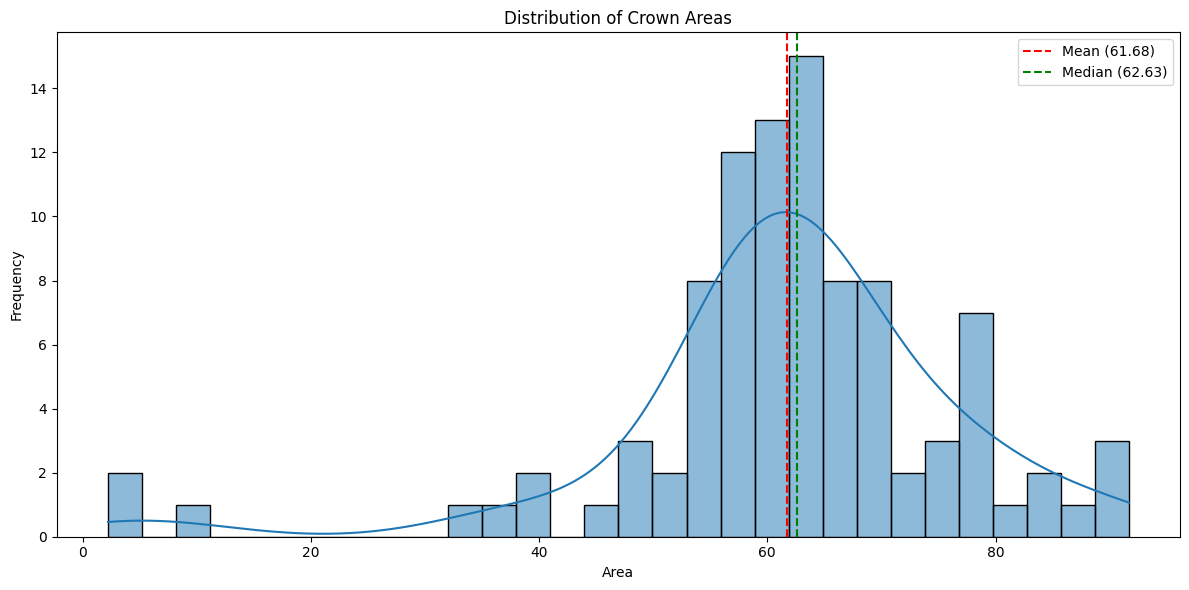

Mean area: 61.68
Lower threshold (0.5 of mean): 30.84
Upper threshold (1.4 of mean): 86.36
Removed 7 outlier crowns:
  - 3 crowns smaller than lower threshold
  - 4 crowns larger than upper threshold
Remaining: 89 crowns
Percentage of total area lost: 6.38%
Percentage of crowns removed: 7.29%


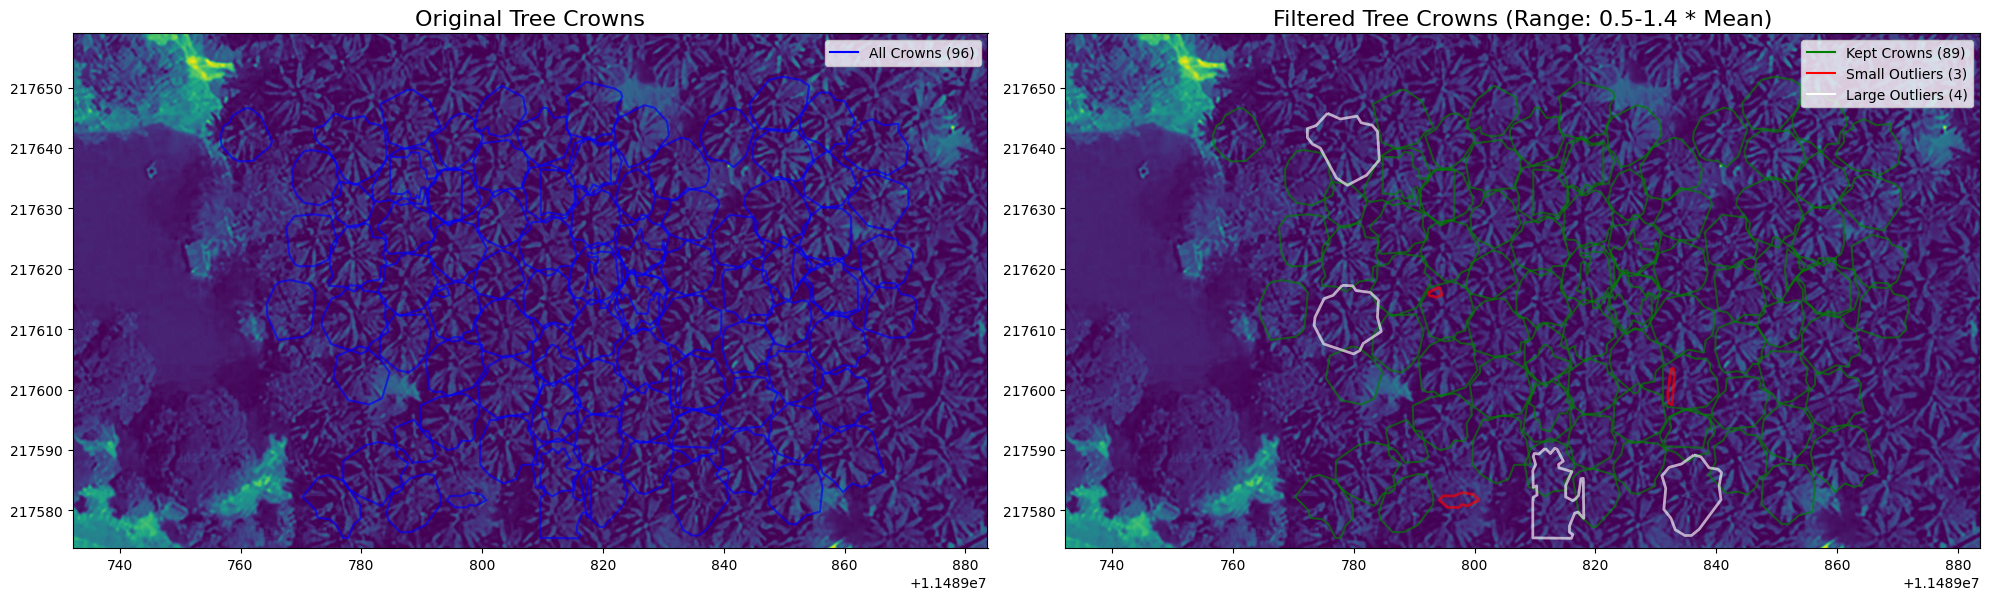

Small outliers count: 3
Large outliers count: 4


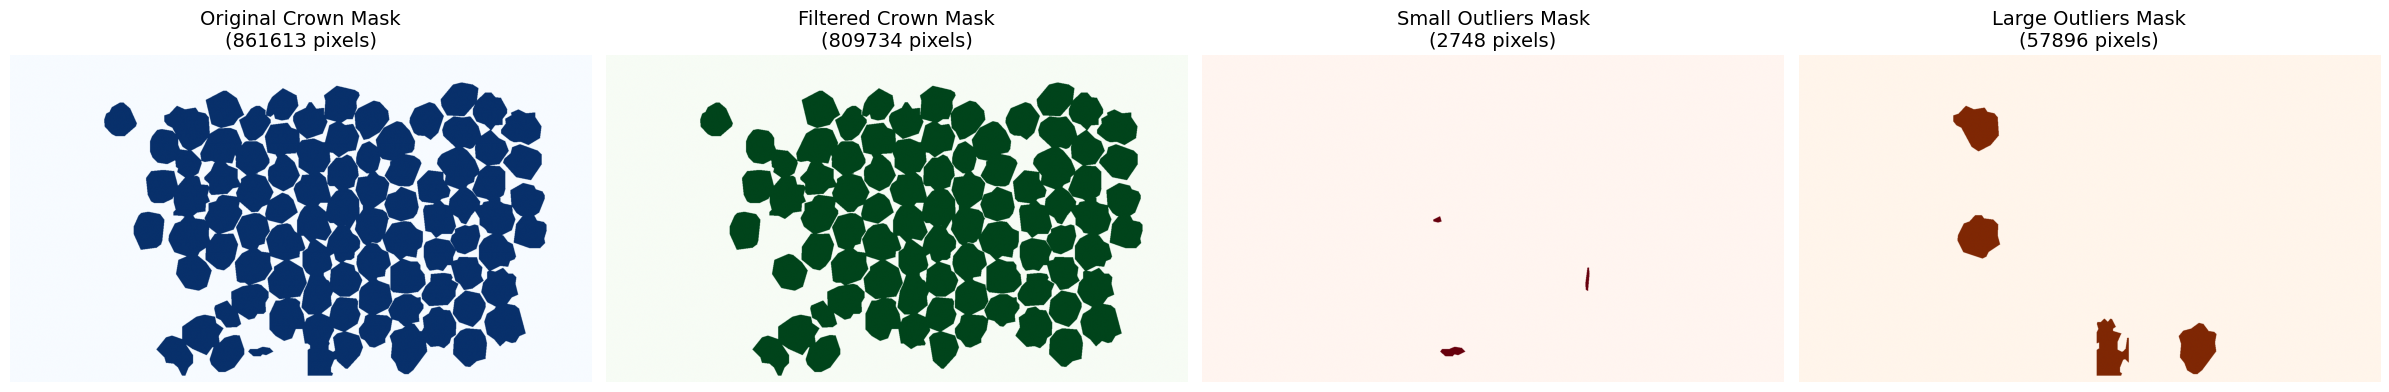

In [4]:
# Load the crown polygons
crowns = gpd.read_file(crowns_path)

# Calculate area for each polygon
crowns['area'] = crowns.geometry.area

# Print summary statistics of the areas
print("Original dataset stats:")
print(f"Count: {len(crowns)}")
print(f"Mean area: {crowns['area'].mean():.2f}")
print(f"Min area: {crowns['area'].min():.2f}")
print(f"Max area: {crowns['area'].max():.2f}")
print(f"Median area: {crowns['area'].median():.2f}")
print(f"Standard deviation: {crowns['area'].std():.2f}")

# Plot histogram of crown areas
plt.figure(figsize=(12, 6))
sns.histplot(crowns['area'], bins=30, kde=True)
plt.axvline(crowns['area'].mean(), color='red', linestyle='--', 
            label=f'Mean ({crowns["area"].mean():.2f})')
plt.axvline(crowns['area'].median(), color='green', linestyle='--', 
            label=f'Median ({crowns["area"].median():.2f})')
plt.title('Distribution of Crown Areas')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
# plt.savefig(site_path + 'filtered/' + "crown_area_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Function to remove outliers based on area threshold
def remove_outlier_crowns(gdf, lower_threshold=0.5, upper_threshold=1.5):
    """
    Remove crowns with area outside the range [lower_threshold * mean_area, upper_threshold * mean_area]
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame containing crown polygons with 'area' column
    lower_threshold (float): Lower bound factor to multiply with mean area
    upper_threshold (float): Upper bound factor to multiply with mean area
    
    Returns:
    GeoDataFrame: Filtered GeoDataFrame with outlier crowns removed
    GeoDataFrame: GeoDataFrame containing only the removed outliers
    """
    mean_area = gdf['area'].mean()
    lower_bound = lower_threshold * mean_area
    upper_bound = upper_threshold * mean_area
    
    print(f"Mean area: {mean_area:.2f}")
    print(f"Lower threshold ({lower_threshold} of mean): {lower_bound:.2f}")
    print(f"Upper threshold ({upper_threshold} of mean): {upper_bound:.2f}")
    
    # Identify outlier crowns (too small or too large)
    is_small = gdf['area'] < lower_bound
    is_large = gdf['area'] > upper_bound
    is_outlier = is_small | is_large
    
    outlier_crowns = gdf[is_outlier].copy()
    filtered_crowns = gdf[~is_outlier].copy()
    
    # Add classification for visualization
    outlier_crowns['outlier_type'] = 'unknown'
    outlier_crowns.loc[is_small, 'outlier_type'] = 'small'
    outlier_crowns.loc[is_large, 'outlier_type'] = 'large'
    
    small_count = sum(is_small)
    large_count = sum(is_large)
    
    print(f"Removed {len(outlier_crowns)} outlier crowns:")
    print(f"  - {small_count} crowns smaller than lower threshold")
    print(f"  - {large_count} crowns larger than upper threshold")
    print(f"Remaining: {len(filtered_crowns)} crowns")

    # Save the filtered crowns to a new gpkg file
    filtered_output_path = site_path + 'filtered/' + "filtered_by_area_crowns.gpkg"
    filtered_crowns.to_file(filtered_output_path, driver="GPKG")
    
    return filtered_crowns, outlier_crowns

# Remove outlier crowns with area outside 50-150% of the mean
lower_threshold = 0.5  # 50% of mean
upper_threshold = 1.4  # 150% of mean
filtered_crowns, outlier_crowns = remove_outlier_crowns(crowns, lower_threshold, upper_threshold)

# Calculate the percentage of area lost and percentage of crowns removed
total_area_original = crowns['area'].sum()
total_area_filtered = filtered_crowns['area'].sum()
area_lost = total_area_original - total_area_filtered
percent_area_lost = (area_lost / total_area_original) * 100
percent_crowns_removed = (len(outlier_crowns) / len(crowns)) * 100

print(f"Percentage of total area lost: {percent_area_lost:.2f}%")
print(f"Percentage of crowns removed: {percent_crowns_removed:.2f}%")

# Open the original raster image
with rasterio.open(img_path) as src:
    image = src.read()  # Read all bands
    transform = src.transform
    crs = src.crs

# Function to visualize original crowns vs filtered crowns
def plot_crowns_comparison(image, transform, original_crowns, filtered_crowns, outlier_crowns, output_path):
    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    # Ensure all GeoDataFrames have the same CRS as the raster
    if original_crowns.crs != crs:
        original_crowns = original_crowns.to_crs(crs)
    if filtered_crowns.crs != crs:
        filtered_crowns = filtered_crowns.to_crs(crs)
    if outlier_crowns.crs != crs:
        outlier_crowns = outlier_crowns.to_crs(crs)
    
    # Plot the image on both subplots
    for ax in axs:
        if image.shape[0] == 3:
            # Normalize each band for better visualization
            rgb = np.zeros((image.shape[1], image.shape[2], 3))
            for i in range(3):
                band = image[i]
                band_min, band_max = np.percentile(band[band > 0], (2, 98))
                rgb[:, :, i] = np.clip((band - band_min) / (band_max - band_min), 0, 1)
            show(rgb, ax=ax, transform=transform)
        else:
            # If it's a single band or more than 3 bands, display the first band
            show(image[0], ax=ax, cmap='viridis', transform=transform)
    
    # Left subplot: Original crowns
    original_crowns.plot(ax=axs[0], facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.65)
    axs[0].set_title('Original Tree Crowns', fontsize=16)
    
    # Right subplot: Filtered crowns (kept) and outliers (removed)
    filtered_crowns.plot(ax=axs[1], facecolor='none', edgecolor='green', linewidth=1.5, alpha=0.65)
    
    # Plot small outliers in red and large outliers in white
    small_outliers = outlier_crowns[outlier_crowns['outlier_type'] == 'small']
    large_outliers = outlier_crowns[outlier_crowns['outlier_type'] == 'large']
    
    small_outliers.plot(ax=axs[1], facecolor='none', edgecolor='red', linewidth=2.0, alpha=0.65)
    large_outliers.plot(ax=axs[1], facecolor='none', edgecolor='white', linewidth=2.0, alpha=0.65)
    
    axs[1].set_title(f'Filtered Tree Crowns (Range: {lower_threshold}-{upper_threshold} * Mean)', fontsize=16)
    
    # Add legends
    legend_elements_original = [
        Line2D([0], [0], color='blue', lw=1.5, label=f'All Crowns ({len(original_crowns)})')
    ]
    axs[0].legend(handles=legend_elements_original, loc='upper right')
    
    legend_elements_filtered = [
        Line2D([0], [0], color='green', lw=1.5, label=f'Kept Crowns ({len(filtered_crowns)})'),
        Line2D([0], [0], color='red', lw=1.5, label=f'Small Outliers ({len(small_outliers)})'),
        Line2D([0], [0], color='white', lw=1.5, label=f'Large Outliers ({len(large_outliers)})')
    ]
    axs[1].legend(handles=legend_elements_filtered, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Visualize the original vs filtered crowns
plot_crowns_comparison(
    image, transform, 
    crowns, filtered_crowns, outlier_crowns,
    site_path + 'filtered/' + "crowns_filtered_comparison.png"
)

# Create crown masks
original_mask_path = create_crown_mask(img_path, crowns, 
                                      site_path + 'filtered/' + "crown_mask_original.tif")
filtered_mask_path = create_crown_mask(img_path, filtered_crowns, 
                                      site_path + 'filtered/' + "crown_mask_area_filtered.tif")
outlier_mask_path = create_crown_mask(img_path, outlier_crowns, 
                                     site_path + 'filtered/' + "crown_mask_area_outliers.tif")

# Create separate masks for small and large outliers
small_outliers = outlier_crowns[outlier_crowns['outlier_type'] == 'small']
large_outliers = outlier_crowns[outlier_crowns['outlier_type'] == 'large']

# Add some debug info to see if the DataFrames are empty
print(f"Small outliers count: {len(small_outliers)}")
print(f"Large outliers count: {len(large_outliers)}")

small_mask_path = create_crown_mask(img_path, small_outliers, 
                                   site_path + 'filtered/' + "crown_mask_small_outliers.tif")

large_mask_path = create_crown_mask(img_path, large_outliers, 
                                   site_path + 'filtered/' + "crown_mask_large_outliers.tif")

# Modify the visualization function to handle empty masks
def visualize_masks(original_mask_path, filtered_mask_path, outlier_mask_path, output_path, small_outlier_mask_path=None, large_outlier_mask_path=None):
    """Visualize the different crown masks"""
    with rasterio.open(original_mask_path) as src_orig, \
         rasterio.open(filtered_mask_path) as src_filt, \
         rasterio.open(outlier_mask_path) as src_out:
        
        orig_mask = src_orig.read(1)
        filt_mask = src_filt.read(1)
        out_mask = src_out.read(1)
        
        # Check if we should use the split outlier view
        use_split_view = False
        if small_outlier_mask_path and large_outlier_mask_path:
            # Check if any of the outlier masks contain data
            with rasterio.open(small_outlier_mask_path) as src_small:
                small_mask = src_small.read(1)
                small_has_data = np.any(small_mask > 0)
                
            with rasterio.open(large_outlier_mask_path) as src_large:
                large_mask = src_large.read(1)
                large_has_data = np.any(large_mask > 0)
                
            use_split_view = small_has_data or large_has_data
        
        if use_split_view:
            # We show separate small and large outlier masks
            fig, axs = plt.subplots(1, 4, figsize=(24, 6))
            
            # Original mask
            axs[0].imshow(orig_mask, cmap='Blues')
            axs[0].set_title(f'Original Crown Mask\n({np.sum(orig_mask)} pixels)', fontsize=14)
            axs[0].axis('off')
            
            # Filtered mask
            axs[1].imshow(filt_mask, cmap='Greens')
            axs[1].set_title(f'Filtered Crown Mask\n({np.sum(filt_mask)} pixels)', fontsize=14)
            axs[1].axis('off')
            
            # Small outlier mask
            axs[2].imshow(small_mask, cmap='Reds')
            title_text = f'Small Outliers Mask\n({np.sum(small_mask)} pixels)'
            if not small_has_data:
                title_text += '\n(No small outliers)'
            axs[2].set_title(title_text, fontsize=14)
            axs[2].axis('off')
            
            # Large outlier mask
            axs[3].imshow(large_mask, cmap='Oranges')
            title_text = f'Large Outliers Mask\n({np.sum(large_mask)} pixels)'
            if not large_has_data:
                title_text += '\n(No large outliers)'
            axs[3].set_title(title_text, fontsize=14)
            axs[3].axis('off')
            
        else:
            # We only show the combined outlier mask
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            
            # Original mask
            axs[0].imshow(orig_mask, cmap='Blues')
            axs[0].set_title(f'Original Crown Mask\n({np.sum(orig_mask)} pixels)', fontsize=14)
            axs[0].axis('off')
            
            # Filtered mask
            axs[1].imshow(filt_mask, cmap='Greens')
            axs[1].set_title(f'Filtered Crown Mask\n({np.sum(filt_mask)} pixels)', fontsize=14)
            axs[1].axis('off')
            
            # Outlier mask
            axs[2].imshow(out_mask, cmap='Reds')
            title_text = f'Removed Outliers Mask\n({np.sum(out_mask)} pixels)'
            if np.sum(out_mask) == 0:
                title_text += '\n(No outliers)'
            axs[2].set_title(title_text, fontsize=14)
            axs[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()

# Visualize the masks
visualize_masks(
    original_mask_path, filtered_mask_path, outlier_mask_path,
    site_path + 'filtered/' + "crown_masks_area_comparison.png",
    small_mask_path, large_mask_path
)

## 2. Remove by overlapping area

In [5]:
# optional
crowns_path = site_path + 'filtered/' + "filtered_by_area_crowns.gpkg"
crowns = gpd.read_file(crowns_path)

Removed 8 inner overlapping crowns (> 50%)
Created mask of outlier crowns at: sample_data/filtered/outlier_overlap_crowns_mask.tif
Created mask of filtered crowns at: sample_data/filtered/filtered_overlap_crowns_mask.tif
Saved filtered crowns to: sample_data/filtered/filtered_by_overlap_crowns.gpkg


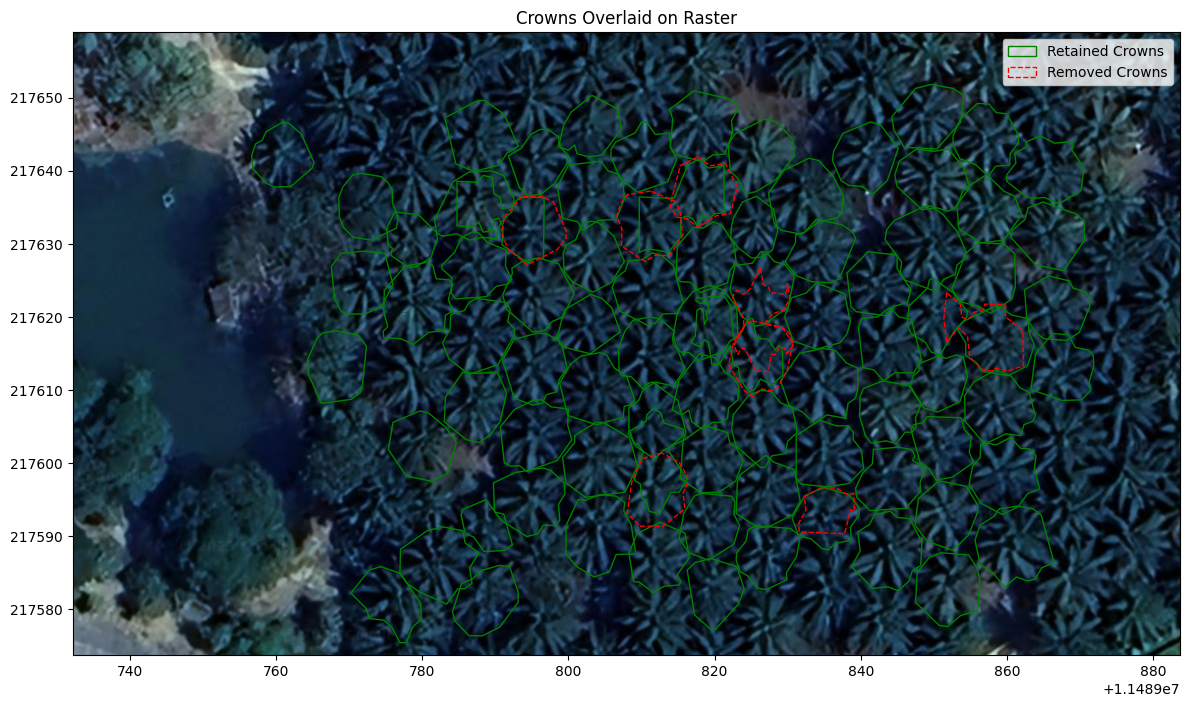

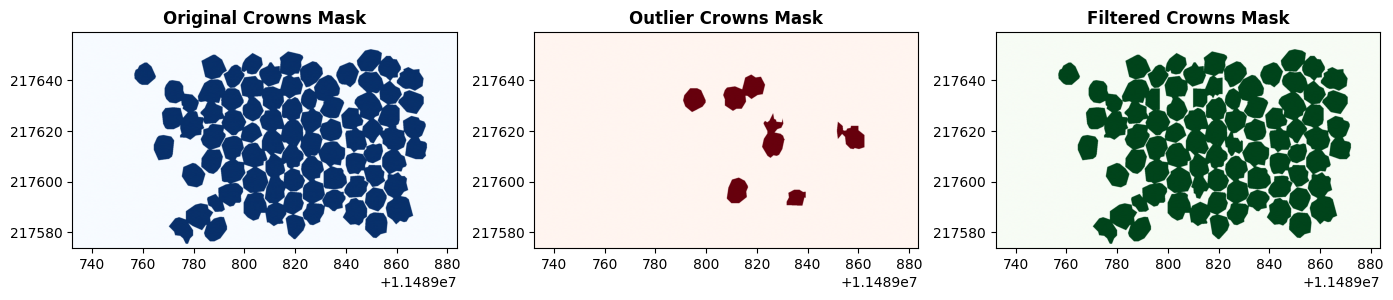

In [6]:
def remove_overlapping_crowns_spatial(gdf, overlap_threshold=0.5):
    """
    Efficiently removes inner crowns that overlap more than a threshold of their own area with any nearby crown,
    using spatial indexing. When two crowns overlap significantly, the inner (smaller area) crown is removed.
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with crown polygons
    overlap_threshold (float): Overlap threshold (e.g., 0.5 = 50%)
    
    Returns:
    tuple: (filtered_gdf, removed_gdf)
    """
    gdf = gdf.reset_index(drop=True).copy()
    
    # Calculate area for each polygon and add as a column
    gdf['area'] = gdf.geometry.area
    
    spatial_index = gdf.sindex
    to_remove = set()
    
    # Process polygons in order of area (smallest first)
    for idx in gdf.sort_values('area').index:
        if idx in to_remove:
            continue
            
        geom = gdf.geometry[idx]
        
        # Find candidates via bounding box intersection
        possible_matches_index = list(spatial_index.intersection(geom.bounds))
        possible_matches_index = [i for i in possible_matches_index if i != idx]
        
        for other_idx in possible_matches_index:
            if other_idx in to_remove:
                continue
                
            other_geom = gdf.geometry[other_idx]
            if not geom.intersects(other_geom):
                continue
                
            intersection = geom.intersection(other_geom)
            if intersection.is_empty:
                continue
                
            # Calculate overlap ratios for both polygons
            this_overlap_ratio = intersection.area / geom.area
            other_overlap_ratio = intersection.area / other_geom.area
            
            # If sufficient overlap exists, remove the smaller crown (inner crown)
            if this_overlap_ratio > overlap_threshold or other_overlap_ratio > overlap_threshold:
                # Compare areas to determine which is the inner (smaller) polygon
                if gdf.at[idx, 'area'] <= gdf.at[other_idx, 'area']:
                    to_remove.add(idx)
                    break
                else:
                    to_remove.add(other_idx)
    
    removed_gdf = gdf.loc[list(to_remove)].copy()
    filtered_gdf = gdf.drop(index=list(to_remove)).reset_index(drop=True)
    removed_gdf = removed_gdf.reset_index(drop=True)
    
    # Drop the temporary area column
    if 'area' in filtered_gdf.columns:
        filtered_gdf = filtered_gdf.drop('area', axis=1)
    if 'area' in removed_gdf.columns:
        removed_gdf = removed_gdf.drop('area', axis=1)
    
    print(f"Removed {len(removed_gdf)} inner overlapping crowns (> {int(overlap_threshold * 100)}%)")
    return filtered_gdf, removed_gdf

def plot_crowns_on_raster(raster_path, retained_gdf, removed_gdf, title="Crowns Overlaid on Raster", output_path=None):
    """
    Plots retained and removed crowns on top of the raster image.
    
    Parameters:
    raster_path (str): Path to the GeoTIFF raster
    retained_gdf (GeoDataFrame): Crowns that were retained
    removed_gdf (GeoDataFrame): Crowns removed due to overlaps
    title (str): Title for the plot
    """
    with rasterio.open(raster_path) as src:
        fig, ax = plt.subplots(figsize=(12, 10))
        show(src, ax=ax)
        
        # Plot retained crowns
        retained_gdf.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=1, label='Retained Crowns')
        
        # Plot removed crowns
        removed_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, linestyle='--', label='Removed Crowns')
        
        # Add legend and title
        legend_elements = [
            Patch(facecolor='none', edgecolor='green', label='Retained Crowns'),
            Patch(facecolor='none', edgecolor='red', linestyle='--', label='Removed Crowns')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        ax.set_title(title)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()

original_mask_path = create_crown_mask(img_path, crowns, 
                                    site_path + 'filtered/' + "crown_mask_original.tif")
# Apply overlap filtering
filtered_crowns, removed_crowns = remove_overlapping_crowns_spatial(crowns, overlap_threshold=0.5)

# Create mask for outlier crowns (those being removed)
outlier_crowns_mask_path = site_path + 'filtered/' + "outlier_overlap_crowns_mask.tif"
create_crown_mask(img_path, removed_crowns, outlier_crowns_mask_path)
print(f"Created mask of outlier crowns at: {outlier_crowns_mask_path}")

# Create mask for filtered crowns (those being kept)
filtered_crowns_mask_path = site_path + 'filtered/' + "filtered_overlap_crowns_mask.tif"
create_crown_mask(img_path, filtered_crowns, filtered_crowns_mask_path)
print(f"Created mask of filtered crowns at: {filtered_crowns_mask_path}")

# Save filtered crowns as vector data
filtered_output_path = site_path + 'filtered/' + "filtered_by_overlap_crowns.gpkg"
filtered_crowns.to_file(filtered_output_path, driver="GPKG")
print(f"Saved filtered crowns to: {filtered_output_path}")

# Plot with raster
plot_crowns_on_raster(img_path, filtered_crowns, removed_crowns, output_path=site_path + 'filtered/' + "crowns_overlap_comparison.png")

# Plot all masks
plot_masked_rasters(
    original_mask_path, 
    outlier_crowns_mask_path, 
    filtered_crowns_mask_path,
    site_path + 'filtered/' + "crown_masked_overlap_comparison.png"
)

## 3. Remove by KD Tree

In [ ]:
%pip install scipy

In [7]:
# optional
crowns_path = site_path + 'filtered/' + "filtered_by_overlap_crowns.gpkg"
crowns = gpd.read_file(crowns_path)

Mean distance to 3 nearest neighbors: 9.10
Standard deviation: 1.48
Lower threshold (0.5×mean): 4.55
Upper threshold (2.0×mean): 18.20
Removed 0 crowns that were too close
Removed 1 crowns that were too far
Retained 80 crowns
240
4
Created mask of outlier crowns at: sample_data/filtered/outlier_knn_crowns_mask.tif
Created mask of filtered crowns at: sample_data/filtered/filtered_knn_crowns_mask.tif
Saved filtered crowns to: sample_data/filtered/filtered_by_knn_crowns.gpkg


/tmp/ipykernel_194964/1026580971.py:74: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  outlier_crowns[outlier_crowns['outlier_type'] == 'too_close'].plot(


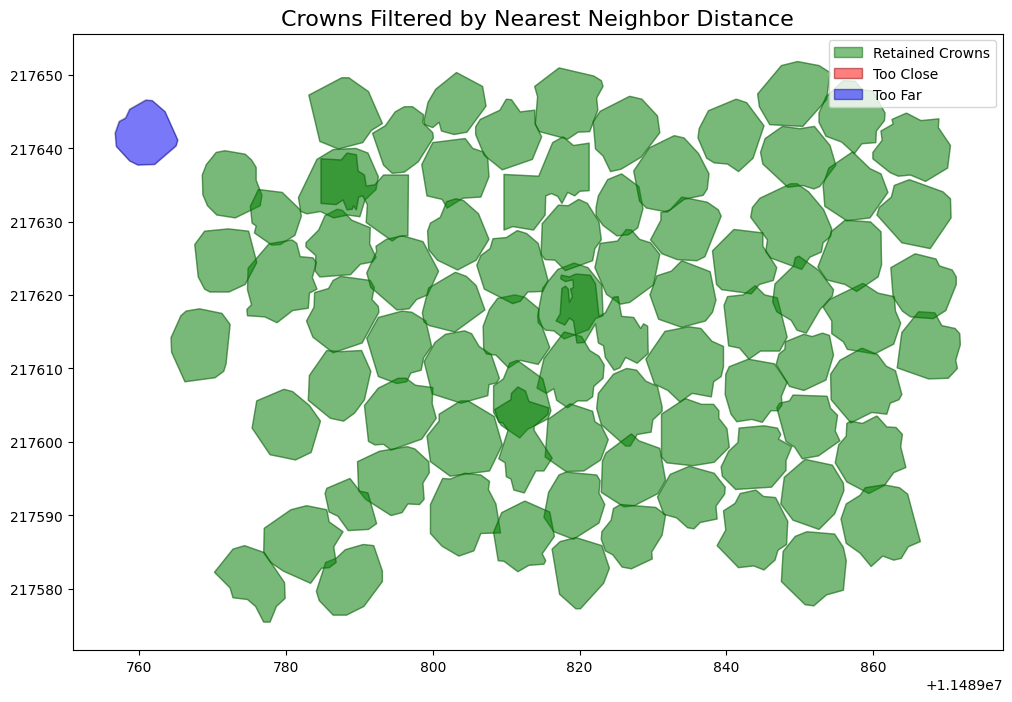

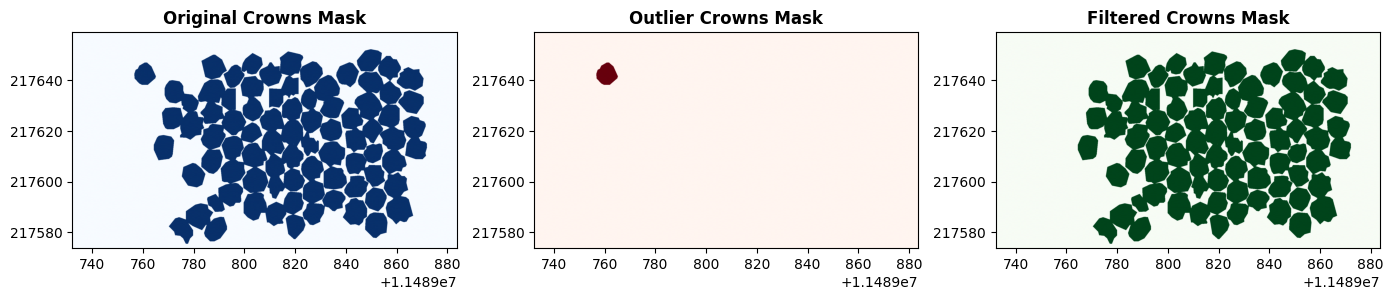

In [8]:
from scipy.spatial import cKDTree  # type: ignore

def calculate_nearest_neighbor_distances(gdf, k=3):
    """
    Calculate the average distance to k nearest neighbors (excluding self)
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with point geometries
    k (int): Number of nearest neighbors to consider
    
    Returns:
    numpy array: Average distance to k nearest neighbors (excluding self)
    """
    coords = np.array([(geom.x, geom.y) for geom in gdf.geometry])
    tree = cKDTree(coords)
    distances, _ = tree.query(coords, k=k+1)  # +1 to include the point itself
    return distances[:, 1:].mean(axis=1)  # exclude the self-distance

def filter_by_neighbor_distance(gdf, lower_factor=0.5, upper_factor=2.0, k=5):
    """
    Filter crowns based on mean distance to k nearest neighbors
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with polygons
    lower_factor (float): Lower threshold as a factor of mean distance
    upper_factor (float): Upper threshold as a factor of mean distance
    k (int): Number of nearest neighbors
    
    Returns:
    tuple: (filtered_gdf, outlier_gdf, distances)
    """
    centroids = gdf.copy()
    centroids['geometry'] = centroids.geometry.centroid
    
    distances = calculate_nearest_neighbor_distances(centroids, k=k)
    
    gdf = gdf.copy()
    gdf['nn_distance'] = distances
    
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    lower_bound = lower_factor * mean_dist
    upper_bound = upper_factor * mean_dist
    
    print(f"Mean distance to {k} nearest neighbors: {mean_dist:.2f}")
    print(f"Standard deviation: {std_dist:.2f}")
    print(f"Lower threshold ({lower_factor}×mean): {lower_bound:.2f}")
    print(f"Upper threshold ({upper_factor}×mean): {upper_bound:.2f}")
    
    is_too_close = gdf['nn_distance'] < lower_bound
    is_too_far = gdf['nn_distance'] > upper_bound
    is_outlier = is_too_close | is_too_far
    
    outlier_gdf = gdf[is_outlier].copy()
    filtered_gdf = gdf[~is_outlier].copy()
    
    outlier_gdf['outlier_type'] = 'unknown'
    outlier_gdf.loc[is_too_close, 'outlier_type'] = 'too_close'
    outlier_gdf.loc[is_too_far, 'outlier_type'] = 'too_far'
    
    print(f"Removed {is_too_close.sum()} crowns that were too close")
    print(f"Removed {is_too_far.sum()} crowns that were too far")
    print(f"Retained {len(filtered_gdf)} crowns")
    
    return filtered_gdf, outlier_gdf, distances

def plot_crowns_on_raster(crowns, filtered_crowns, outlier_crowns, output_path):
    """
    Plot crowns without background and save to file.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    crowns.plot(ax=ax, facecolor='lightgray', edgecolor='gray', alpha=0.3)
    filtered_crowns.plot(ax=ax, facecolor='green', edgecolor='darkgreen', alpha=0.5)
    outlier_crowns[outlier_crowns['outlier_type'] == 'too_close'].plot(
        ax=ax, facecolor='red', edgecolor='darkred', alpha=0.5)
    outlier_crowns[outlier_crowns['outlier_type'] == 'too_far'].plot(
        ax=ax, facecolor='blue', edgecolor='darkblue', alpha=0.5)

    plt.title('Crowns Filtered by Nearest Neighbor Distance', fontsize=16)
    legend_elements = [
        Patch(facecolor='green', edgecolor='darkgreen', alpha=0.5, label='Retained Crowns'),
        Patch(facecolor='red', edgecolor='darkred', alpha=0.5, label='Too Close'),
        Patch(facecolor='blue', edgecolor='darkblue', alpha=0.5, label='Too Far')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# crowns_path = site_path + 'filtered/' + "filtered_by_area_crowns.gpkg"
# crowns = gpd.read_file(crowns_path)
original_mask_path = create_crown_mask(img_path, crowns, 
                                    site_path + 'filtered/' + "crown_mask_original.tif")
# Apply knn filtering
filtered_crowns, outlier_crowns, distances = filter_by_neighbor_distance(crowns, k=3)
print(filtered_crowns.size)
print(outlier_crowns.size)

# Create mask for outlier crowns (those being removed)
outlier_knn_crowns_mask_path = site_path + 'filtered/' + "outlier_knn_crowns_mask.tif"
create_crown_mask(img_path, outlier_crowns, outlier_knn_crowns_mask_path)
print(f"Created mask of outlier crowns at: {outlier_knn_crowns_mask_path}")

# Create mask for filtered crowns (those being kept)
filtered_knn_crowns_mask_path = site_path + 'filtered/' + "filtered_knn_crowns_mask.tif"
create_crown_mask(img_path, filtered_crowns, filtered_knn_crowns_mask_path)
print(f"Created mask of filtered crowns at: {filtered_knn_crowns_mask_path}")

# Save filtered crowns as vector data
filtered_output_path = site_path + 'filtered/' + "filtered_by_knn_crowns.gpkg"
filtered_crowns.to_file(filtered_output_path, driver="GPKG")
print(f"Saved filtered crowns to: {filtered_output_path}")

plot_crowns_on_raster(crowns, filtered_crowns, outlier_crowns, site_path + 'filtered/' + "crown_knn_comparison.png")

# Plot all masks
plot_masked_rasters(
    original_mask_path, 
    outlier_knn_crowns_mask_path, 
    filtered_knn_crowns_mask_path,
    site_path + 'filtered/' + "crown_masked_knn_comparison.png"
)

## Visualize

In [10]:
crowns_path = site_path + 'filtered/' + "filtered_by_knn_crowns.gpkg"
crowns = gpd.read_file(crowns_path)

Number of crowns: 80


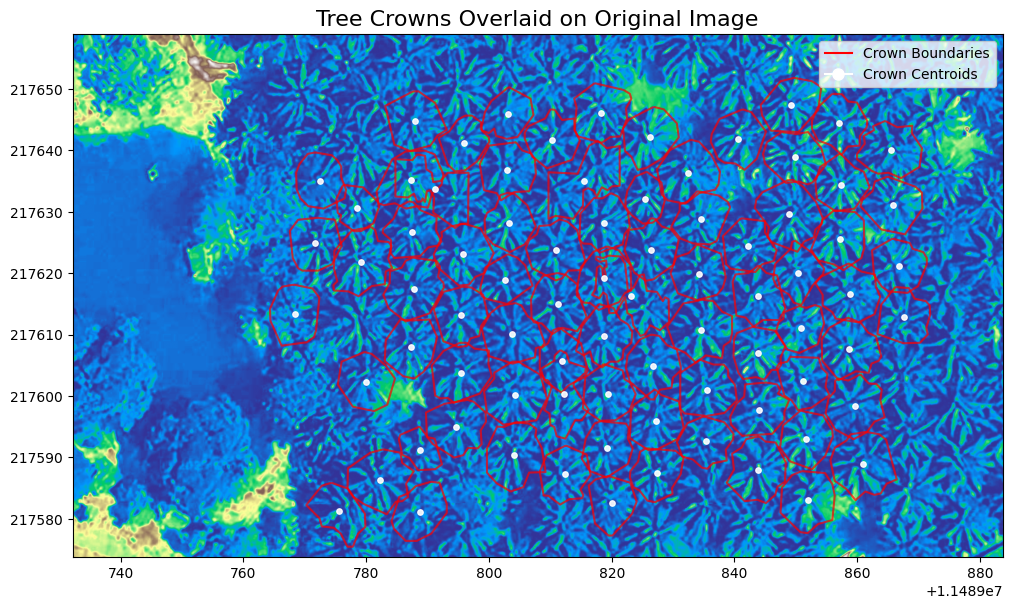

In [ ]:
# Open the original raster image
with rasterio.open(img_path) as src:
    image = src.read()  # Read all bands
    transform = src.transform
    crs = src.crs
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the image
    # If the image has 3 bands (RGB), display it as a color image
    if image.shape[0] == 3:
        # Normalize each band for better visualization
        rgb = np.zeros((image.shape[1], image.shape[2], 3))
        for i in range(3):
            band = image[i]
            band_min, band_max = np.percentile(band[band > 0], (2, 98))
            rgb[:, :, i] = np.clip((band - band_min) / (band_max - band_min), 0, 1)
        show(rgb, ax=ax, transform=transform)
    else: 
        # If it's a single band or more than 3 bands, display the first band
        show(image[0], ax=ax, cmap='terrain', transform=transform)
    
    # Make sure crowns has the same CRS as the raster
    if crowns.crs != crs:
        crowns = crowns.to_crs(crs)
    
    # Plot the crowns with a semi-transparent fill and bold outline
    crowns.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.5, alpha=0.7)
    
    # Add centroids for reference
    centroids = crowns.copy()
    centroids['geometry'] = centroids.geometry.centroid
    print(f'Number of crowns: {len(centroids)}')
    centroids.plot(ax=ax, color='orange', markersize=15, alpha=0.9)
    
    # Add a title and labels
    plt.title('Tree Crowns Overlaid on Original Image', fontsize=16)
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=1.5, label='Crown Boundaries'),
        Line2D([0], [0], marker='o', color='orange', markerfacecolor='orange', 
               markersize=8, label='Crown Centroids')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Save the figure
    plt.savefig(site_path + "/filtered_crowns_overlay.png", dpi=300, bbox_inches='tight')
    plt.show()

# Optional: Create a mask from the crowns
def create_crown_mask(raster_path, crowns_gdf, output_path):
    """Create a binary mask raster from crown polygons"""
    with rasterio.open(raster_path) as src:
        # Create a blank raster with the same dimensions
        mask = np.zeros((src.height, src.width), dtype=np.uint8)
        
        # Make sure crowns has the same CRS as the raster
        if crowns_gdf.crs != src.crs:
            crowns_gdf = crowns_gdf.to_crs(src.crs)
        
        # Rasterize the crowns
        from rasterio.features import rasterize
        shapes = [(mapping(geom), 1) for geom in crowns_gdf.geometry]
        mask = rasterize(shapes, out_shape=(src.height, src.width), 
                         transform=src.transform, fill=0, default_value=1)
        
        # Create a new raster file with the mask
        profile = src.profile.copy()
        profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(mask, 1)
    
    return output_path